In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import torch
import warnings
from typing import Dict, Any
from torch.utils.data import Dataset
from transformers import (
    pipeline,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

/workspaces/Rreview_Analyzer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../data/cleaned_data.csv')

#### Data Preprocessing

Text(0.5, 1.0, 'Review Length Distribution')

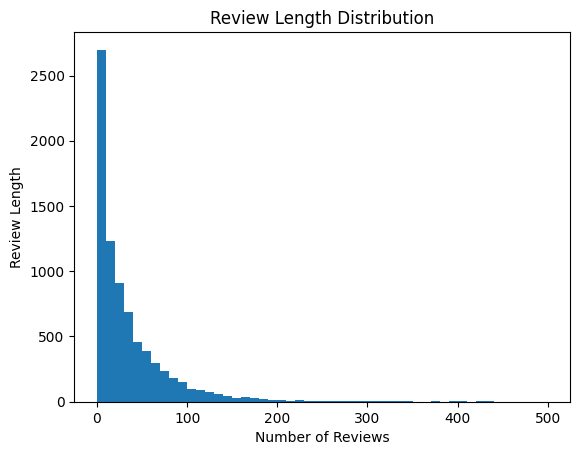

In [4]:
df['reviewText'].str.split().str.len().plot(kind='hist', bins=50, range=(0, 500))
plt.xlabel('Number of Reviews')
plt.ylabel('Review Length')
plt.title('Review Length Distribution')

In [5]:
# Check the maximum word count
max_word_count = df['reviewText'].str.split().str.len().max()
print(f"Maximum word count: {max_word_count}")

# Check distribution at higher thresholds
for threshold in [50, 100, 500, 1000, 2000, 3000]:
    count = (df['reviewText'].str.split().str.len() > threshold).sum()
    print(f"Reviews with more than {threshold} words: {count}")

Maximum word count: 3695
Reviews with more than 50 words: 1825
Reviews with more than 100 words: 613
Reviews with more than 500 words: 6
Reviews with more than 1000 words: 1
Reviews with more than 2000 words: 1
Reviews with more than 3000 words: 1


In [6]:
# Remove reviews with More than 100 words
# Set word count threshold
threshold = 100

# Original size before filtering
original_size = len(df)

# Create a boolean mask for reviews below the threshold
mask = df['reviewText'].str.split().str.len() <= threshold

# Apply the mask to filter the DataFrame
df = df[mask]

# Reset index after filtering
df.reset_index(drop=True, inplace=True)

# Check the new size
new_size = len(df)

print(f"Original data size: {original_size}")
print(f"New data size: {new_size}")
print(f"Total of {original_size - new_size} reviews were deleted")

Original data size: 7857
New data size: 7244
Total of 613 reviews were deleted


In [7]:
# Regex cleaning
def clean_text(text):
    """
    Comprehensive text cleaning function that applies multiple preprocessing steps.
    Args:
        text (str): Input text to be cleaned
    Returns:
        str: Cleaned text with punctuation, URLs, hashtags, usernames removed
    """
    # Compile regex patterns once for better performance
    patterns = [
        (r'http\S+', ''),           # Remove URLs more comprehensively
        (r'#\w+', ''),               # Remove hashtags
        (r'@\w+', ''),               # Remove usernames
        (r'[^\w\s]', ''),            # Remove punctuation
        (r'\s+', ' '),               # Replace multiple whitespaces with single space
        (r'\s\.?\s', ' ')            # Remove single characters between spaces
    ]

    # Apply all patterns in sequence
    for pattern, repl in patterns:
        text = re.sub(pattern, repl, text)

    return text.strip().lower()

In [8]:
# Apply the function to the filtered data
df['reviewText'] = df['reviewText'].apply(lambda x: clean_text(x))

#### Label Data

In [9]:
# Create a Label column
# Load a sentiment analysis model
sentiment_pipeline = pipeline("sentiment-analysis", model="tabularisai/robust-sentiment-analysis")

# Apply the pipeline to the reviewText column
df['sentiment'] = df['reviewText'].apply(lambda x: sentiment_pipeline(x)[0]["label"])

df.head()

Device set to use cpu


,Unnamed: 0,index,authorName,googleMapsPlaceId,placeAddress,placeName,placeUrl,provider,reviewDate,reviewRating,...,reviewImages/4,reviewImages/5,reviewImages/6,reviewImages/7,reviewImages/8,reviewImages/9,reviewImages/10,reviewImages/11,reviewImages/12,sentiment
0,0,1,Lindsey L,ChIJAQReQIdZwokR1rcwiar_XqM,"Orchard Grocer, 78 Orchard St, New York, NY 10...",Orchard Grocer,https://page-service.doordash.com/store/orchar...,door-dash,2022-02-21,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very Positive
1,1,2,Mara R,ChIJAQReQIdZwokR1rcwiar_XqM,"Orchard Grocer, 78 Orchard St, New York, NY 10...",Orchard Grocer,https://page-service.doordash.com/store/orchar...,door-dash,2024-12-19,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very Positive
2,2,3,Yvette Y,ChIJAQReQIdZwokR1rcwiar_XqM,"Orchard Grocer, 78 Orchard St, New York, NY 10...",Orchard Grocer,https://page-service.doordash.com/store/orchar...,door-dash,2024-10-13,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very Negative
3,3,4,Hugh M,ChIJAQReQIdZwokR1rcwiar_XqM,"Orchard Grocer, 78 Orchard St, New York, NY 10...",Orchard Grocer,https://page-service.doordash.com/store/orchar...,door-dash,2024-07-22,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive
4,4,5,Erin L,ChIJAQReQIdZwokR1rcwiar_XqM,"Orchard Grocer, 78 Orchard St, New York, NY 10...",Orchard Grocer,https://page-service.doordash.com/store/orchar...,door-dash,2024-04-11,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very Positive


In [8]:
# Delete the Unnamed column
df = df.loc[:, ~df.columns.str.match('Unnamed')]

Text(0.5, 1.0, 'Sentiment Distribution')

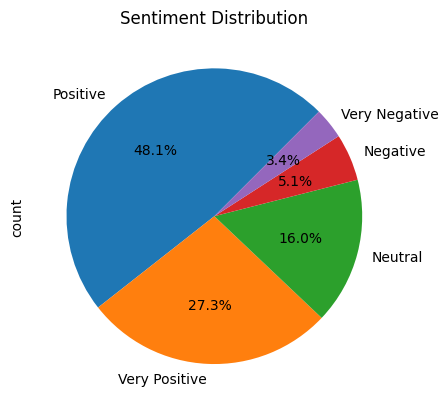

In [11]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=45)
plt.title('Sentiment Distribution')

#### Convert text labels to numbers

In [12]:
label_mapping = {"Very Negative": 0, "Negative": 0,"Very Positive": 1, "Positive": 1, "Neutral": 2 }
df['label'] = df['sentiment'].map(label_mapping)

Text(0, 0.5, 'Count')

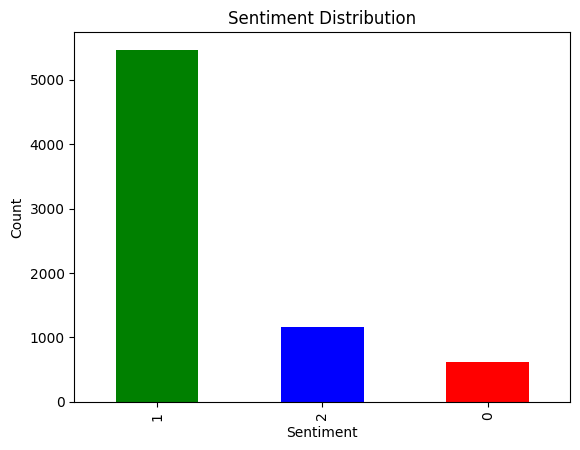

In [13]:
df['label'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

#### Split Data

In [14]:
# Split the data into training, validation, and testing sets
train_text, temp_text, train_sentiment, temp_sentiment = train_test_split(
    df["reviewText"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

val_text, test_text, val_sentiment, test_sentiment = train_test_split(
    temp_text, temp_sentiment, test_size=0.5, random_state=42
)

##### Tokenization

In [15]:
model_checkpoint = "distilbert-base-uncased"
output_dir = 'models/semtiment_model'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


#### Create a dataset class

In [17]:
def tokenize_texts(texts):
    """Tokenizes a list of texts using the pretrained tokenizer."""
    return tokenizer(texts, truncation=True, padding=True, return_tensors="pt")  # returns BatchEncoding object

class SentimentDataset(Dataset):
    """
Custom PyTorch Dataset for sentiment classification.
Args:
    encodings (Dict): Tokenized input encodings
    labels (List): Corresponding sentiment labels
"""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


    def __len__(self):
        return len(self.labels)

# Tokenize datasets
train_dataset = SentimentDataset(tokenize_texts(train_text), train_sentiment)
val_dataset = SentimentDataset(tokenize_texts(val_text), val_sentiment)
test_dataset = SentimentDataset(tokenize_texts(test_text), test_sentiment)

#### Train the Model

In [18]:
def compute_metrics(pred):
    """
    Compute evaluation metrics for the model.
    Args:
        pred: Prediction results from Trainer
    Returns:
        Dict of evaluation metrics
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy
    accuracy = accuracy_score(labels, preds)

    # Generate classification report
    class_report = classification_report(labels, preds, output_dict=True)

    return {
        'accuracy': accuracy,
        'precision': class_report['macro avg']['precision'],
        'recall': class_report['macro avg']['recall'],
        'f1': class_report['macro avg']['f1-score']
    }

def train(
    train_dataset: Dataset,
    val_dataset: Dataset,
    batch_size: int = 16,
    num_train_epochs: int = 3
):
    """
    Train the sentiment analysis model.
    Args:
        train_dataset (Dataset): Training dataset
        val_dataset (Dataset): Validation dataset
        batch_size (int): Training batch size
        num_train_epochs (int): Number of training epochs

    Returns:
        Trained model
    """
    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'{output_dir}/logs',
        logging_steps=10,
        learning_rate = 2e-5,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy'
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    trainer.train()

    return model

#### Model Evaluation

In [19]:
def evaluate(test_dataset):
    """
    Evaluate the model on test dataset.
    Args:
        test_dataset (Dataset): Test dataset
    Returns:
        Dictionary of evaluation metrics
    """
    trainer = Trainer(
        model=model,
        compute_metrics=compute_metrics
    )

    # Evaluate the model
    eval_results = trainer.evaluate(test_dataset)
    return eval_results

#### Save & Load the Model for Future Use

In [20]:
def save_model(model, tokenizer):
    """Save the trained model and tokenizer."""
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

In [21]:
# Train the model
trained_model = train(train_dataset, val_dataset)

/workspaces/Rreview_Analyzer/.venv/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_22281/3166517172.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


: 

In [42]:
# Evaluation
evaluate(test_dataset)

<ipython-input-26-f465a081ce40>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.24844014644622803,
 'eval_model_preparation_time': 0.0024,
 'eval_accuracy': 0.8979310344827586,
 'eval_precision': 0.8136519578847746,
 'eval_recall': 0.8284466284466285,
 'eval_f1': 0.8205603597908245,
 'eval_runtime': 9.7107,
 'eval_samples_per_second': 74.66,
 'eval_steps_per_second': 9.371}

In [40]:
# saving the Model
save_model(model, tokenizer)